In [32]:
## generating single .smi file
## obabel single_smiles.smi -O output.sdf --gen2d (testing single smiles)
## obabel doublemontecarlogen3D412.xyz -O output.sdf
## obabel singular_smiles.smi -O output.sdf --gen2d -m (5 files, seeing if it's sorted in order)
## obabel smiles.smi -O output.sdf --gen2d -m
## obabel is sorted in order 1-n
import pandas as pd
import os
df = pd.read_csv("/Users/leiapei/Downloads/501_SMILES.csv",header=None)
smiles = df.iloc[:,0]
with open("/Users/leiapei/Downloads/2dshifts/smiles.smi",'w') as f:
    for each in smiles:
      f.write(each+"\n")

unprocessed_names=df.iloc[:,1].tolist()
#corresponding_smiles = df.iloc[:,0].tolist()
new_names=[] # ordered
for line in unprocessed_names:
    index=line.index('/')+1
    name=line[index:]
    new_names.append(name)
# print(new_names)
# print(new_names[500])
data_directory="/Users/leiapei/Downloads/2dshifts/2d_data"
print(new_names)
for i in range(len(os.listdir(data_directory))):
   current = data_directory+"/output"+str(i+1)+".sdf"
   if os.path.basename(current) == ("output"+str(i+1)+".sdf"):
      os.rename((current),(data_directory+"/"+new_names[i]+".sdf"))
   else:
      print("mismatch error, no corresponding 2d file to rename!")
## directory is sorted from 1-n, does not keep the order of the original 501_smiles.csv montecarlo names
## must index using the file basename, not by order!

['doublemontecarlogen3D101', 'doublemontecarlogen3D102', 'doublemontecarlogen3D103', 'doublemontecarlogen3D10', 'doublemontecarlogen3D125', 'doublemontecarlogen3D126', 'doublemontecarlogen3D12', 'doublemontecarlogen3D134', 'doublemontecarlogen3D135', 'doublemontecarlogen3D136', 'doublemontecarlogen3D137', 'doublemontecarlogen3D138', 'doublemontecarlogen3D139', 'doublemontecarlogen3D140', 'doublemontecarlogen3D141', 'doublemontecarlogen3D142', 'doublemontecarlogen3D143', 'doublemontecarlogen3D144', 'doublemontecarlogen3D145', 'doublemontecarlogen3D146', 'doublemontecarlogen3D147', 'doublemontecarlogen3D148', 'doublemontecarlogen3D149', 'doublemontecarlogen3D14', 'doublemontecarlogen3D150', 'doublemontecarlogen3D151', 'doublemontecarlogen3D152', 'doublemontecarlogen3D153', 'doublemontecarlogen3D154', 'doublemontecarlogen3D155', 'doublemontecarlogen3D156', 'doublemontecarlogen3D157', 'doublemontecarlogen3D158', 'doublemontecarlogen3D159', 'doublemontecarlogen3D15', 'doublemontecarlogen3D1

FileNotFoundError: [Errno 2] No such file or directory: '/Users/leiapei/Downloads/2dshifts/2d_data/output1.sdf' -> '/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D101.sdf'

In [2]:
## processing the sdf files
## obabel *.sdf -ogpr -m
## atomic mass , number , electronegativity
import os
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import BaggingRegressor
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from mendeleev import element

num = 1
path = ""
directories = os.listdir("/Users/leiapei/Downloads/2dshifts/2d_data")

def extract_shifts(file_path):
    with open(file_path, "r") as file:
        file_content = file.read()
    chemical_shielding_index = file_content.find("CHEMICAL SHIELDING SUMMARY")
    text_after_chemical_shielding = file_content[chemical_shielding_index:]

    lines = text_after_chemical_shielding.split("\n")
    lines = [line.strip() for line in lines]
    lines = lines[1:]
    numbers = []
    for line in lines:
        if line.strip().startswith("-") or line.strip().startswith("Nucleus"):
            continue
        if (line.strip().startswith("Maximum")):
            break
        if line.strip():
            columns = line.split()
            isotropic_value = columns[2]
            numbers.append(float(isotropic_value))
    return numbers


def read_sdf(file_path):
    print(file_path)
    with open(file_path, "r") as f:
        count = 0
        f=f.readlines()
        f=f[3:] # take away header

        atomic_coords=[]
        atomic_numbers=[]
        atom_types=[]
        masses = []
        ens = []
        count_line_block = f[0].strip().split()
        numAtoms = int(count_line_block[0])

        i=1
        while i<numAtoms:
            line = f[i].strip().split()
            #print(line[:2])
            x,y=map(float, line[:2])
            atom=line[3]
            atomic_coords.append([x,y])
            atom_types.append(atom)
            el = element(atom)
            ens.append(el.en_pauling)
            masses.append(el.mass_number)
            atomic_numbers.append(el.atomic_number)
            i+=1
    f_neighbors_5 = []
    f_neighbors_4 = []
    f_neighbors_3 = []
    f_neighbors_2 = []
    index = 0
    for i in range(len(atom_types)):
        if (atom_types[i] is "F"):
            x = atomic_coords[i][0]
            y = atomic_coords[i][1]
            f_neighbors_5.append(list())
            f_neighbors_4.append(list())
            f_neighbors_3.append(list())
            f_neighbors_2.append(list())
            for j in range(len(atom_types)):
                if (j != i):
                    en = ens[j]
                    mass = masses[j]
                    dist_x = (atomic_coords[j][0] - x) ** 2
                    dist_y = (atomic_coords[j][1] - y) ** 2
                    distance = math.sqrt(dist_x + dist_y)
                    # features: atomic symbol, distance from F, atomic #, 
                    if (distance <= 5):
                        # Features: Neighbor identity, distance from the fluorine, charge, atomic number, electronegativity, mass number
                        f_neighbors_5[index].append([atom_types[j], distance, atomic_numbers[j], en, mass])
                    if (distance <= 4):
                        f_neighbors_4[index].append([atom_types[j], distance, atomic_numbers[j], en, mass])
                    if (distance <= 3):
                        f_neighbors_3[index].append([atom_types[j], distance, atomic_numbers[j], en, mass])
                    if (distance <= 2):
                        f_neighbors_2[index].append([atom_types[j], distance, atomic_numbers[j], en, mass])
            index += 1
    return f_neighbors_5,f_neighbors_4,f_neighbors_3,f_neighbors_2
        #print(atomic_coords)
        #print(atom_types)
def process_sdf_files(directory):
    data_2 = pd.DataFrame(columns=['neighbors', 'chemical_shift'])
    data_3 = pd.DataFrame(columns=['neighbors', 'chemical_shift'])
    data_4 = pd.DataFrame(columns=['neighbors', 'chemical_shift'])
    data_5 = pd.DataFrame(columns=['neighbors', 'chemical_shift'])
    print("Processing...")
    for filename in os.listdir(directory):
        # for ghemical files + shifts
        if filename == ".DS_Store":
            continue
        basename, extension = os.path.splitext(filename)
        file_path = os.path.join(directory, filename) #.sdf files
        shift_path = os.path.join("/Users/leiapei/Downloads/all_shifts", f'{basename}.out') #.out files
        fn5,fn4,fn3,fn2 = read_sdf(file_path)
        ##I USED FN3 ONLY TO TEST THE DATA PROCESSING, BUT YOU SHOULD RUN
        ##THE MODELS USING FN3 ONLY AND FN2 ONLY TO COMPARE THEIR RESULTS
        shifts = extract_shifts(shift_path)
        #print(len(fn3))=
        print(basename)
        print(len(fn3))
        print(len(shifts))
        for i in range(len(fn2)):
            row = {
                'neighbors': fn2[i],  
                'chemical_shift': shifts[i]  
            }
            data_2 = data_2._append(row, ignore_index=True)
        for i in range(len(fn3)):
            row = {
                'neighbors': fn3[i], 
                'chemical_shift': shifts[i]  
            }
            data_3 = data_3._append(row, ignore_index=True)
        for i in range(len(fn4)):
            row = {
                'neighbors': fn4[i],  
                'chemical_shift': shifts[i]  
            }
            data_4 = data_4._append(row, ignore_index=True)
        for i in range(len(fn5)):
            row = {
                'neighbors': fn5[i],  
                'chemical_shift': shifts[i] 
            }
            data_5 = data_5._append(row, ignore_index=True)
    print("Processing complete")
    return data_5, data_4, data_3, data_2

directory = "/Users/leiapei/Downloads/2dshifts/2d_data"
data_5, data_4, data_3, data_2 = process_sdf_files(directory)
data_5.to_csv("data_5.csv")
data_4.to_csv("data_4.csv")
data_3.to_csv("data_3.csv")
data_2.to_csv("data_2.csv")

<>:103: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:103: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/pc/8l24y3n97hn2gcy57mk8crw80000gn/T/ipykernel_10839/4187269314.py:103: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if (atom_types[i] is "F"):


Processing...
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D374.sdf
doublemontecarlogen3D374
6
6
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D412.sdf


/var/folders/pc/8l24y3n97hn2gcy57mk8crw80000gn/T/ipykernel_10839/4187269314.py:157: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_2 = data_2._append(row, ignore_index=True)
/var/folders/pc/8l24y3n97hn2gcy57mk8crw80000gn/T/ipykernel_10839/4187269314.py:163: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_3 = data_3._append(row, ignore_index=True)
/var/folders/pc/8l24y3n97hn2gcy57mk8crw80000gn/T/ipykernel_10839/4187269314.py:169: FutureWarning: The behavior of DataFrame concatenation with 

doublemontecarlogen3D412
3
3
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D406.sdf
doublemontecarlogen3D406
3
3
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D360.sdf
doublemontecarlogen3D360
3
3
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D348.sdf
doublemontecarlogen3D348
3
3
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D610.sdf
doublemontecarlogen3D610
1
1
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D176.sdf
doublemontecarlogen3D176
1
1
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D162.sdf
doublemontecarlogen3D162
1
1
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D604.sdf
doublemontecarlogen3D604
3
3
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D2.sdf
doublemontecarlogen3D2
1
1
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D36.sdf
doublemontecarlogen3D36
3
3
/Users/leiapei/Downloads/2dshifts/2d_data/doublemontecarlogen3D22.sdf
doublem

In [57]:
# importing necessary modules and libraries
import pandas as pd
import time
import warnings
import pickle
from bayes_opt import BayesianOptimization
#from hyperopt import fmin, tpe, hp, Trials

from skopt import BayesSearchCV
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from skopt.space import Real, Integer, Categorical

# Import top 4 best performers (GBR, BR, RF, KNN)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

# Suppressing all warnings for clean outputs
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import ast
np.int = int
from sklearn.metrics import mean_absolute_error, r2_score

# Read in all the datasets for each angstrom level into pandas dataframes
data_5 = pd.read_csv("/Users/leiapei/Downloads/2dshifts/data_5.csv")
data_4 = pd.read_csv("/Users/leiapei/Downloads/2dshifts/data_4.csv")
data_3 = pd.read_csv("/Users/leiapei/Downloads/2dshifts/data_3.csv")
data_2 = pd.read_csv("/Users/leiapei/Downloads/2dshifts/data_2.csv")

# Function to "flatten" all input features for each fluorine atom's neighbors (distance, id, charge, atomic number, electronegativity, mass number)
def flatten_neighbors_with_types(neighbors):
    # Initialized lists for input features
    flattened_distances = []
    flattened_neighbors = []
    flattened_nums = []
    flattened_en = []
    flattened_mass = []
    max_length = max(len(neighbor_list) for neighbor_list in neighbors)
    # Iterating through each neighboring atom neighbors list
    for neighbor_list in neighbors:
        distances = []
        neighbor_types = []
        nums = []
        ens = []
        masses = []
        # Extract all desired features in order of storage in neighbor_list
        for neighbor, distance, num, en, mass in neighbor_list:
            distances.append(distance) 
            neighbor_types.append(neighbor)   
            nums.append(num)
            ens.append(en)
            masses.append(mass)
        # Pad the lists with zeros to match the length of the longest list; required for regression models
        padding_length = max_length - len(distances) # 12 - len(distances)
        distances.extend([0] * padding_length)
        neighbor_types.extend([0] * padding_length)
        nums.extend([0] * padding_length)
        masses.extend([0] * padding_length)
        ens.extend([0] * padding_length)
        # Append padded data to their "flattened" sets
        flattened_distances.append(distances)
        flattened_neighbors.append(neighbor_types)
        flattened_nums.append(nums)
        flattened_en.append(ens)
        flattened_mass.append(masses)
    return flattened_distances, flattened_neighbors, flattened_nums, flattened_en, flattened_mass

# Additional preprocessing; declare parameters and results dataframes to store corresponding values
data_list = [data_5, data_4, data_3, data_2]

# List all models and model parameters, results, and standard errors
models = ['GBR', 'BR', 'RF', 'KNN']
parameters = pd.DataFrame(columns=["Model", "5 angstroms", "4 angstroms", "3 angstroms", "2 angstroms"])
results = pd.DataFrame(columns=["Model", "Metric", "5 angstroms", "4 angstroms", "3 angstroms", "2 angstroms"])
stderr = pd.DataFrame(columns=["Model", "Metric", "5 angstroms", "4 angstroms", "3 angstroms", "2 angstroms"])
models_column = list()
metrics_column = list()

# For each model run, store MAE, R-sqyared, and Runtime
for model in models:
    models_column.append(model)
    models_column.append(model)
    models_column.append(model)
    metrics_column.append("MAE")
    metrics_column.append("R^2")
    metrics_column.append("Runtime")

# Assign appropriate columns of results DataFrame to metrics and models
# Assign models to Model columns of parameters and stderr DataFrames
results["Model"] = models_column
results["Metric"] = metrics_column
parameters["Model"] = models
stderr["Model"] = models

print(results.head())
print("Dataframe Done")

## ALL MODELS WILL UNDERGO BAYESIAN OPTIMIZATION, OR SOME VARIANT OF BAYESIAN OPTIMIZATION.
# THE GENERAL TUNING PROCESSES ARE IDENTICAL AND DOCUMENTED FOR THE FIRST FEW MODELS 

# Note: Selection of bayes_opt library vs BayesSearchCV was based on observed performance with both tuning methods (best performing selected). Hyperparameter bounds were either selected arbitrarily or adjusted based on observed performance. 

## Tuning Decision Trees 

# Loop through all 5 angstrom level sets, starting from 5 (index)
index = 5

# Loop through each dataset in the data_list
for data in data_list:
    # Column name is defined on currect index
    column = f'{index} angstroms'
    index -= 1
    # Flatten neighbors with types into feature vectors
    distances, neighbors, nums, en, mass = flatten_neighbors_with_types(data['neighbors'].apply(ast.literal_eval))
    # Encode atom types using one-hot encoding (into one-hot vectors)
    encoder = OneHotEncoder(sparse_output=False)
    # Convert lists to numpy arrays for further processing
    atom_types_encoded = encoder.fit_transform(np.array(neighbors))  # Encode atom types
    distances_encoded = np.array(distances)
    nums = np.array(nums)
    en = np.array(en)
    mass = np.array(mass)
    # Add features to input data
    X_encoded = np.hstack([distances_encoded, atom_types_encoded, nums, en, mass])
    # Initialize target output
    y = data['chemical_shift']
    # Split the data into training and testing sets with 80-20 ratio
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

## Tuning Random Forest
# Defines hyperparameter search space for the model.
rf_param_space = {
    'n_estimators': Integer(10, 300), 
    'max_depth': Integer(3, 20), 
    'min_samples_split': Integer(2, 20), 
    'min_samples_leaf': Integer(1, 20),
    'max_features': Categorical(['log2', 'sqrt', None]),  
    'bootstrap': Categorical([True, False])
}

# Sets up "BayesSearchCV" for model tuning
rf_bayes_search = BayesSearchCV(
    RandomForestRegressor(),
    rf_param_space,
    # Sets up scoring metric, cross-validation fold, parameter settings, and seed
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=50,
    random_state=42
)

# Iterates through the data list, processes datasets, and updates respective DataFrames
index = 5
for data in data_list:
    # Defines the column name based on the current index value.
    column = f'{index} angstroms'
    index -= 1
    distances, neighbors, nums, en, mass = flatten_neighbors_with_types(data['neighbors'].apply(ast.literal_eval))
    # Encode atom types.
    encoder = OneHotEncoder(sparse_output=False)
    atom_types_encoded = encoder.fit_transform(np.array(neighbors))  # Encode atom types
    distances_encoded = np.array(distances)
    nums = np.array(nums)
    en = np.array(en)
    mass = np.array(mass)
    X_encoded = np.hstack([distances_encoded, atom_types_encoded, nums, en, mass])
    y = data['chemical_shift']
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    # Fits random forest model to training sets
    print("Fitting RF...")
    rf_bayes_search.fit(X_train, y_train)
    start_time = time.time()
    best_rf = rf_bayes_search.best_estimator_
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)
    end_time = time.time()
    runtime = end_time - start_time
    # Sets metric values
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stderror = y_test.sub(y_pred).abs().sem()
    stderr.loc[(stderr["Model"] == "RF"), column] = stderror
    parameters.loc[(parameters["Model"] == "RF"), column] = str(rf_bayes_search.best_params_)
    results.loc[(results["Model"] == "RF") & (results["Metric"] == "MAE"), column] = mae
    results.loc[(results["Model"] == "RF") & (results["Metric"] == "R^2"), column] = r2
    results.loc[(results["Model"] == "RF") & (results["Metric"] == "Runtime"), column] = runtime
    pickle_file = f"/Users/leiapei/Downloads/2dshifts/model_files/RF_{index+1}.pkl"

    # Saves model to a pickle file
    with open(pickle_file, 'wb') as file:
        pickle.dump(best_rf, file)
print("3) RF done")

# Saves current results, parameters, and values to csv files
results.to_csv("results_temp_2.csv", index=False)
parameters.to_csv("parameters_temp_2.csv", index=False)
stderr.to_csv("stderr_temp_2.csv", index=False)

# Reloads the saved csv files
stderr = pd.read_csv("stderr_temp_2.csv")
parameters = pd.read_csv("parameters_temp_2.csv")
results = pd.read_csv("results_temp_2.csv")

## Tuning Gradient Boosting Regression with Decision Trees (high-performing model!)
# Defines a dictionary specifying range and hyperparameters for GBR
gbdt_param_space = {
    'learning_rate': (0.001, 1.0, 'log-uniform'),  # Learning rate for gradient boosting
    'n_estimators': (10, 300),                     # Number of boosting stages
    'max_depth': (3, 20),                          # Maximum depth of the individual regression estimators
    'min_samples_split': (2, 20),                  # Minimum number of samples required to split an internal node
    'min_samples_leaf': (1, 20),                   # Minimum number of samples required to be at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider when looking for the best split
    'subsample': (0.1, 1.0, 'uniform')             # Fraction of samples used for fitting the individual base learners
}

# Utilizes Bayesian Optimization to search for the best hyperparameters
gbdt_bayes_search = BayesSearchCV(
    GradientBoostingRegressor(),
    gbdt_param_space,
    scoring='neg_mean_absolute_error',
    cv=5,
    n_iter=50, 
    random_state=42
)
index = 5
# Loops over datasets
for data in data_list:
    column = f'{index} angstroms'
    index -= 1
    distances, neighbors, nums, en, mass = flatten_neighbors_with_types(data['neighbors'].apply(ast.literal_eval))
    # Encodes atom types
    encoder = OneHotEncoder(sparse_output=False)
    atom_types_encoded = encoder.fit_transform(np.array(neighbors))  # Encode atom types
    distances_encoded = np.array(distances)
    nums = np.array(nums)
    en = np.array(en)
    mass = np.array(mass)
    X_encoded = np.hstack([distances_encoded, atom_types_encoded, nums, en, mass])
    y = data['chemical_shift']
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    print("Fitting GBR...")
    # Fits GradientBoostingRegressor to find best hyperparameters
    gbdt_bayes_search.fit(X_train, y_train)
    best_gbdt = gbdt_bayes_search.best_estimator_
    # best_gbdt = GradientBoostingRegressor(**OrderedDict([('learning_rate', 0.083759380187059), ('max_depth', 20), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 19), ('n_estimators', 300), ('subsample', 0.8480243834493593)]))
    start_time = time.time()
    best_gbdt.fit(X_train, y_train)
    y_pred = best_gbdt.predict(X_test)
    end_time = time.time()
    # Stores MAE, R-squared, and standard error
    runtime = end_time - start_time
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stderror = y_test.sub(y_pred).abs().sem()
    stderr.loc[(stderr["Model"] == "GBR"), column] = stderror
    parameters.loc[(parameters["Model"] == "GBR"), column] = str(gbdt_bayes_search.best_params_)
    results.loc[(results["Model"] == "GBR") & (results["Metric"] == "MAE"), column] = mae
    results.loc[(results["Model"] == "GBR") & (results["Metric"] == "R^2"), column] = r2
    results.loc[(results["Model"] == "GBR") & (results["Metric"] == "Runtime"), column] = runtime
    pickle_file = f"/Users/leiapei/Downloads/2dshifts/model_files/GBR_{index+1}.pkl"
    # Saves model to a pickle file
    with open(pickle_file, 'wb') as file:
        pickle.dump(best_gbdt, file)
    input("Continue?")
print("5) GBR done")
# Saves results, parmeters, standard error to csv files
results.to_csv("results_temp_2.csv", index=False)
parameters.to_csv("parameters_temp_2.csv", index=False)
stderr.to_csv("stderr_temp_2.csv", index=False)

# Reloads saved csv files
stderr = pd.read_csv("stderr_temp_2.csv")
parameters = pd.read_csv("parameters_temp_2.csv")
results = pd.read_csv("results_temp_2.csv")

## Tuning KNN 
# Back to defining the objective function
# Optimizes KNN hyperparameters using Bayesian optimization
def knn_objective(n_neighbors, weights, p, X_train, X_test, y_train, y_test):
    # Sets neighborr and weights to consider
    n_neighbors = int(n_neighbors)
    weights = 'uniform' if weights < 0.5 else 'distance'
    p = int(p)
    # Initializes KNeighborsRegressor with specific hyperparameters 
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    # Calculates MAE
    mae = mean_absolute_error(y_test, y_pred)
    return -mae  
index = 5
# Loops over datasets
for data in data_list:
    column = f'{index} angstroms'
    index -= 1
    distances, neighbors, nums, en, mass = flatten_neighbors_with_types(data['neighbors'].apply(ast.literal_eval))
    # Encodes atom types
    encoder = OneHotEncoder(sparse_output=False)
    atom_types_encoded = encoder.fit_transform(np.array(neighbors))  # Encode atom types
    distances_encoded = np.array(distances)
    nums = np.array(nums)
    en = np.array(en)
    mass = np.array(mass)
    X_encoded = np.hstack([distances_encoded, atom_types_encoded, nums, en, mass])
    y = data['chemical_shift']
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    # Sets search space for Bayesian optimization
    pbounds = {'n_neighbors': (1, 30), 'weights': (0, 1), 'p': (1, 2)}
    # Defines objective function to find best hyperparameters
    optimizer = BayesianOptimization(
        f=lambda n_neighbors, weights, p: knn_objective(n_neighbors, weights, p, X_train, X_test, y_train, y_test),
        pbounds=pbounds,
        random_state=42,
    )
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    n_neighbors = int(best_params['n_neighbors'])
    weights = 'uniform' if best_params['weights'] < 0.5 else 'distance'
    p = int(best_params['p'])
    print("Best Hyperparameters:", best_params)
    start_time = time.time()
    # Trains a KNeighborsRegressor on best hyperparameters
    knn = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    end_time = time.time()
    # Sets performance metrics
    runtime = end_time - start_time
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stderror = y_test.sub(y_pred).abs().sem()
    stderr.loc[(stderr["Model"] == "KNN"), column] = stderror
    parameters.loc[(parameters["Model"] == "KNN"), column] = str(best_params)
    results.loc[(results["Model"] == "KNN") & (results["Metric"] == "MAE"), column] = mae
    results.loc[(results["Model"] == "KNN") & (results["Metric"] == "R^2"), column] = r2
    results.loc[(results["Model"] == "KNN") & (results["Metric"] == "Runtime"), column] = runtime
    pickle_file = f"/Users/leiapei/Downloads/2dshifts/model_files/KNN_{index+1}.pkl"
    # Saves model to a pickle file
    with open(pickle_file, 'wb') as file:
        pickle.dump(knn, file)

print("6) KNN done")

# Saves results to csv files
results.to_csv("results_temp_2.csv", index=False)
parameters.to_csv("parameters_temp_2.csv", index=False)
stderr.to_csv("stderr_temp_2.csv", index=False)

# Reloads saved csv files
stderr = pd.read_csv("stderr_temp_2.csv")
parameters = pd.read_csv("parameters_temp_2.csv")
results = pd.read_csv("results_temp_2.csv")

## Tuning Bagging Regressor
# Evaluates performance of Bagging Regressor with hyperparameters
def bagging_regressor_evaluate(n_estimators, max_samples, max_features, X_train, y_train, X_test, y_test):
    n_estimators = int(n_estimators)
    # Initializes the Bagging Regressor with given hyperparameters and sets
    br = BaggingRegressor(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, n_jobs=-1)
    br.fit(X_train, y_train)
    y_pred = br.predict(X_test)
    # Finds R-squared metric
    r2 = r2_score(y_test, y_pred)
    return r2

index = 5
# Loops through datasets
for data in data_list:
    column = f'{index} angstroms'
    index -= 1
    # Process neighbor information
    distances, neighbors, nums, en, mass = flatten_neighbors_with_types(data['neighbors'].apply(ast.literal_eval))
    encoder = OneHotEncoder(sparse_output=False)
    # Encodes atom types
    atom_types_encoded = encoder.fit_transform(np.array(neighbors))
    distances_encoded = np.array(distances)
    nums = np.array(nums)
    en = np.array(en)
    mass = np.array(mass)
    X_encoded = np.hstack([distances_encoded, atom_types_encoded, nums, en, mass])
    # Extracts target variable
    y = data['chemical_shift']
    # Splits data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
    # Defines search space for the hyperparameters
    pbounds = {'n_estimators': (10, 100),
               'max_samples': (0.1, 1.0),
               'max_features': (0.1, 1.0)}
    # Initializes the Bayesian optimizer with the objective function and search space.
    optimizer = BayesianOptimization(
        f=lambda n_estimators, max_samples, max_features: bagging_regressor_evaluate(n_estimators, max_samples, max_features, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test),
        pbounds=pbounds,
        random_state=42,
    )
    # Runs the optimization for 50 iterations after 10 initial random points.
    optimizer.maximize(init_points=10, n_iter=50)
    best_params = optimizer.max['params']
    n_estimators = int(best_params['n_estimators'])
    max_samples = best_params['max_samples']
    max_features = best_params['max_features']
    # Extracts best hyperparameters
    print("Best Hyperparameters:", best_params)
    start_time = time.time()
    br = BaggingRegressor(n_estimators=n_estimators, max_samples=max_samples, max_features=max_features, n_jobs=-1)
    br.fit(X_train, y_train)
    y_pred = br.predict(X_test)
    end_time = time.time()
    # Calculates metric values
    runtime = end_time - start_time
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stderror = y_test.sub(y_pred).abs().sem()
    stderr.loc[(stderr["Model"] == "BR"), column] = stderror
    parameters.loc[(parameters["Model"] == "BR"), column] = str(best_params)
    results.loc[(results["Model"] == "BR") & (results["Metric"] == "MAE"), column] = mae
    results.loc[(results["Model"] == "BR") & (results["Metric"] == "R^2"), column] = r2
    results.loc[(results["Model"] == "BR") & (results["Metric"] == "Runtime"), column] = runtime
    pickle_file = f"model_files/BR_{index+1}.pkl"
    # Saves model to a pickle file
    with open(pickle_file, 'wb') as file:
        pickle.dump(br, file)
print("8) BR done")

# Results, parameters, and standard error save to csv files
results.to_csv("results_temp_2.csv", index=False)
parameters.to_csv("parameters_temp_2.csv", index=False)
stderr.to_csv("stderr_temp_2.csv", index=False)

# Reloads saved csv files
stderr = pd.read_csv("stderr_temp_2.csv")
parameters = pd.read_csv("parameters_temp_2.csv")
results = pd.read_csv("results_temp_2.csv")

  Model   Metric 5 angstroms 4 angstroms 3 angstroms 2 angstroms
0   GBR      MAE         NaN         NaN         NaN         NaN
1   GBR      R^2         NaN         NaN         NaN         NaN
2   GBR  Runtime         NaN         NaN         NaN         NaN
3    BR      MAE         NaN         NaN         NaN         NaN
4    BR      R^2         NaN         NaN         NaN         NaN
Dataframe Done
Fitting RF...
Fitting RF...
Fitting RF...
Fitting RF...
3) RF done
Fitting GBR...
Fitting GBR...
Fitting GBR...
Fitting GBR...
5) GBR done
|   iter    |  target   | n_neig... |     p     |  weights  |
-------------------------------------------------------------
| 1         | -11.16    | 11.86     | 1.951     | 0.732     |
| 2         | -14.04    | 18.36     | 1.156     | 0.156     |
| 3         | -10.05    | 2.684     | 1.866     | 0.6011    |
| 4         | -11.62    | 21.53     | 1.021     | 0.9699    |
| 5         | -14.74    | 25.14     | 1.212     | 0.1818    |
| 6         | -10.05  

[[2.28664887 2.03796718 1.03458245 ... 0.         0.         0.        ]
 [2.72463121 2.1973542  1.22780287 ... 0.         0.         0.        ]
 [2.82928975 2.22659365 0.76950496 ... 0.         0.         0.        ]
 ...
 [2.43861433 2.94262795 1.53004348 ... 0.         0.         0.        ]
 [2.17585102 1.23119579 1.32801901 ... 0.         0.         0.        ]
 [2.72950798 2.62998463 2.24888079 ... 0.         0.         0.        ]]
257
RF
8.70324662298427
0.609065417064182


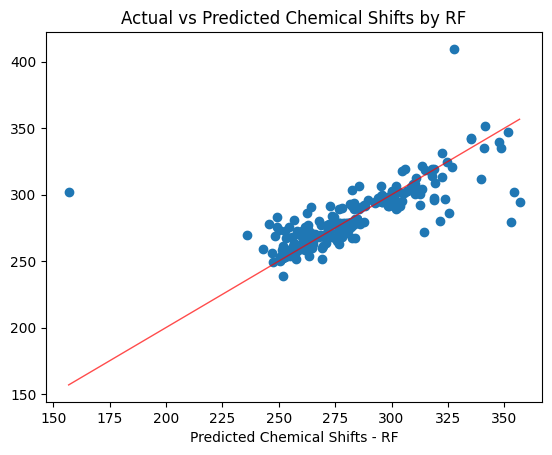

GBR
8.381060962286954
0.6236072574750278


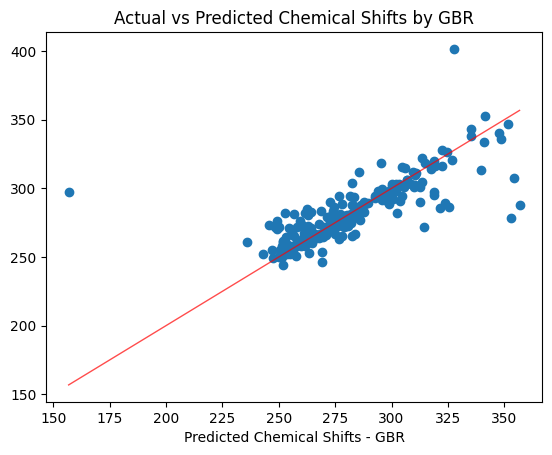

BR
9.643211299380697
0.6047476929415928


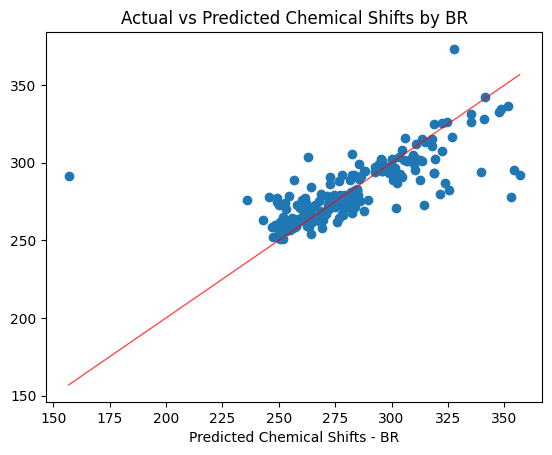

KNN
8.662925041324284
0.620384564677549


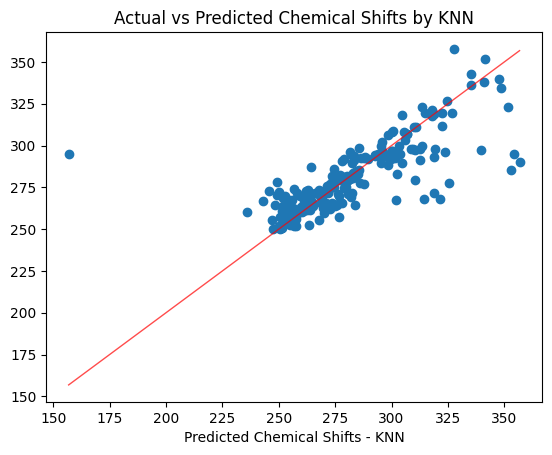

In [59]:
# Import necessary libraries for data manipulation, machine learning, and plotting
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
import pickle
import ast
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

# Initialize list of model names
models = ['RF', 'GBR', 'BR', 'KNN']

# Reads "data_3.csv" into a pandas DataFrame
data = pd.read_csv("data_3.csv")

# Takes a list of neighbor data and flattens it into seperate lists
# for distances, neighbor types, charges, atomic numbers, electronegativities, and masses
# Function to "flatten" all input features for each fluorine atom's neighbors (distance, id, charge, atomic number, electronegativity, mass number)
def flatten_neighbors_with_types(neighbors):
    # Initialized lists for input features
    flattened_distances = []
    flattened_neighbors = []
    flattened_nums = []
    flattened_en = []
    flattened_mass = []
    max_length = max(len(neighbor_list) for neighbor_list in neighbors)
    # Iterating through each neighboring atom neighbors list
    for neighbor_list in neighbors:
        distances = []
        neighbor_types = []
        nums = []
        ens = []
        masses = []
        # Extract all desired features in order of storage in neighbor_list
        for neighbor, distance, num, en, mass in neighbor_list:
            distances.append(distance) 
            neighbor_types.append(neighbor)   
            nums.append(num)
            ens.append(en)
            masses.append(mass)
        # Pad the lists with zeros to match the length of the longest list; required for regression models
        padding_length = max_length - len(distances) # 12 - len(distances)
        distances.extend([0] * padding_length)
        neighbor_types.extend([0] * padding_length)
        nums.extend([0] * padding_length)
        masses.extend([0] * padding_length)
        ens.extend([0] * padding_length)
        # Append padded data to their "flattened" sets
        flattened_distances.append(distances)
        flattened_neighbors.append(neighbor_types)
        flattened_nums.append(nums)
        flattened_en.append(ens)
        flattened_mass.append(masses)
    return flattened_distances, flattened_neighbors, flattened_nums, flattened_en, flattened_mass
          

# Calls "flatten_neighbors_with_types" on DataFrame's "neighbors" column
# Initializes variables for resulting flattened lists
distances, neighbors, nums, en, mass = flatten_neighbors_with_types(data['neighbors'].apply(ast.literal_eval))

# Encode atom types using one-hot encoding (into one-hot vectors)
encoder = OneHotEncoder(sparse_output=False)
# Flattened lists converted into numpy arrays
atom_types_encoded = encoder.fit_transform(np.array(neighbors))  # Encode atom types
distances_encoded = np.array(distances)
nums = np.array(nums)
en = np.array(en)
mass = np.array(mass)

# Comvines all feature arrays into featur matrix (input data)
X_encoded = np.hstack([distances_encoded, atom_types_encoded, nums, en, mass])
print(X_encoded)

# Sets target variable "y" as chemical shifts column (output data)
y = data['chemical_shift']

# Splits data into 80-20 train-test ratio
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)
print(X_test.shape[1])

# Plots model predictions by loading saved models from pickle files and re-evaluating on the test data
for model in models:
    with open(f"/Users/leiapei/Downloads/2dshifts/model_files/{model}_3.pkl", "rb") as pickle_file:
        predictor = pickle.load(pickle_file)
    if (model == "RDG"): # For some reason, loaded RDG predictions are different from the original model's predictions
        predictor.fit(X_train, y_train) # Even after training, predictions are slightly different 
    y_pred = predictor.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    stderror = y_test.sub(y_pred).abs().sem()
    # Prints MAE and R-squared values
    print(model)
    print(mae)
    print(r2)
    # Displays scatter plot comparing chemical shifts "y_test" to predicted chemical shifts "y_pred"
    plt.scatter(y_test, y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red",linewidth=1, alpha=0.7)
    plt.xlabel("DFT Chemical Shifts")
    plt.xlabel(f"Predicted Chemical Shifts - {model}")
    plt.title(f"Actual vs Predicted Chemical Shifts by {model}")
    plt.savefig(f"/Users/leiapei/Downloads/2dshifts/model_predictions/{model}_predictions.png")
    plt.show()